# Exploration of results

**[WARNING]** To run this notebook you will need to have generated the `lemma` and `quotation` dataframes for each headword.

In [1]:
from pathlib import Path
import pandas as pd
from collections import defaultdict,Counter
import statistics
import re

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
# Lemmas grouped by similarity of their most prominent senses:
dLemmas = {"all_lemmas": ["anger_NN","apple_NN","art_NN", "democracy_NN",
                  "happiness_NN", "labour_NN", "machine_NN", "man_NN",
                  "nation_NN", "power_NN", "slave_NN", 'woman_NN'],
           
           "non_industrial": ["anger_NN","apple_NN","democracy_NN",
                  "happiness_NN","man_NN",
                  "nation_NN","slave_NN",'woman_NN'],
           
           "industrial": ["art_NN", "labour_NN", "machine_NN", "power_NN"],
           
           "non_tech": ["anger_NN","apple_NN","art_NN", "democracy_NN",
                  "happiness_NN", "labour_NN", "man_NN",
                  "nation_NN", "slave_NN", 'woman_NN'],
           
           "tech": ["machine_NN", "power_NN"],
           
           "human": ["slave_NN", 'woman_NN', "man_NN"],
           
           "emotion": ["happiness_NN", "anger_NN"],
           
           "abstract": ["happiness_NN", "anger_NN", "art_NN", "democracy_NN",
                  "labour_NN", "nation_NN"],
           
           "abstract_wo_emotions": ["art_NN", "democracy_NN",
                  "labour_NN", "nation_NN"],
           
           "concrete": ["apple_NN", "machine_NN", "man_NN", "slave_NN", 'woman_NN'],
           
           "concrete_wo_machine": ["apple_NN", "man_NN", "slave_NN", 'woman_NN'],
           
           "man_apple_woman": ["apple_NN", "man_NN", 'woman_NN'],
           
           "apple": ["apple_NN"],
           
           "machine": ["machine_NN"],
           
           "slave": ["slave_NN"],
           
           "man_woman": ["man_NN", "woman_NN"],
           
           "all_wo_machine": ["anger_NN","apple_NN","art_NN", "democracy_NN",
                  "happiness_NN", "labour_NN", "man_NN",
                  "nation_NN", "power_NN", "slave_NN", 'woman_NN'],
           
           "work_related": ["slave_NN", "machine_NN", "labour_NN", "power_NN"],
           
           "non_work_related": ["anger_NN","apple_NN","art_NN", "democracy_NN",
                  "happiness_NN", "man_NN",
                  "nation_NN", 'woman_NN']
          }

###  Optimal time range for a Language Model

The following two cells reproduce Figure 1. It finds the optimal date range for the different language models (measured by the F1-score of the positive class) givenn some headwords and using the _sense centroid_ method. Quotations are filtered in moving 100-year time windows.

In [4]:
def find_optimal_daterange(results_path, lemmas, timestart, year_window, metric):
    from sklearn.metrics import precision_recall_fscore_support
    clf_dict = defaultdict(list)
    results = {}
    csv_files = results_path.glob("**/*.csv")
    for csv in csv_files:
        current_csv = str(csv).split("/")
        current_lemma = current_csv[1]
        current_sense = current_csv[3].split("~")[0]
        lemma_pickle = pd.read_pickle("data/lemma_senses_" + current_lemma + ".pickle")
        sst = lemma_pickle[lemma_pickle["id"] == current_sense].iloc[0]["daterange.start"]
            
        try:
            df = pd.read_csv(csv)
            
            df = df[["label","year","quotation_id","bert_centroid_sense_vector_bert_base_-1,-2,-3,-4_mean",
                     "bert_centroid_sense_vector_bert_1850_-1,-2,-3,-4_mean","bert_centroid_sense_vector_blert_-1,-2,-3,-4_mean"]]
            df = df.rename(columns={"bert_centroid_sense_vector_bert_base_-1,-2,-3,-4_mean": "bert_base_sense_centroid",
                                    "bert_centroid_sense_vector_bert_1850_-1,-2,-3,-4_mean": "bert_1850_sense_centroid",
                                    "bert_centroid_sense_vector_blert_-1,-2,-3,-4_mean": "bert_1900_sense_centroid"})
            df = df[df["year"].between(timestart, timestart+(year_window*2))]

        except Exception as e:
            continue
        
        if current_lemma in lemmas:
            for col in df.columns:
                clf_dict[col].extend(df[col])

    for colname, classifications in clf_dict.items():
        if colname not in ('label','year','quotation_id') and colname.startswith("bert_"):
            p,r = [round(x,3) for x in precision_recall_fscore_support(clf_dict['label'],classifications,average='binary',pos_label=1)[:2] if x] 
            f1 = round((2*(p*r))/(p+r),3)
            if metric == "recall":
                results[colname] = round(r,3)
            if metric == "precision":
                results[colname] = round(p,3)
            if metric == "fscore":
                results[colname] = round(f1,3)

    return results

To obtain Figure 1 from the paper, `setting` should be `all_lemmas` and `metric` should be `fscore`.

You can experiment further with other scenarios by changing the metrics and groupings of lemmas.

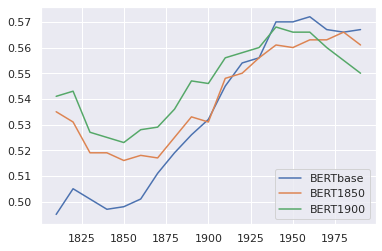

In [5]:
setting = "all_lemmas" # Options: see dictionary "dLemmas" at the beginning of the notebook.
metric = "fscore" # Options: "precision", "recall", "fscore" (this always corresponds to the positive class)

lemmas = dLemmas[setting]

path = Path('figures')
path.mkdir(exist_ok=True)

time_experiment = 2000 # Folder from which we select results
test_daterange_start = 1760 # Quotations starting from
year_window = 50
bert_base = []
bert_1850 = []
bert_1900 = []
time_mean = []
for date_start in range(test_daterange_start, time_experiment - year_window,10):
    results = find_optimal_daterange(Path('results_' + str(time_experiment)), lemmas, date_start, year_window, metric)
    bert_base.append(results["bert_base_sense_centroid"])
    bert_1850.append(results["bert_1850_sense_centroid"])
    bert_1900.append(results["bert_1900_sense_centroid"])
    time_mean.append(date_start + year_window)
    
plt.plot(time_mean, bert_base)
plt.plot(time_mean, bert_1850)
plt.plot(time_mean, bert_1900)

plt.legend(["BERTbase", "BERT1850", "BERT1900"], loc='lower right')

plt.savefig(path / ("plot_LM_" + setting + "_class1" + metric + "_50.png"), dpi=300, bbox_inches="tight")

###  Optimal time range for a Language Model: weighted sense centroid

This does the same as the preceding two cells, but for the time-sensitive approaches.

In [8]:
def find_optimal_daterange_ts(results_path, lemmas, timestart, year_window, metric, weighting):
    from sklearn.metrics import precision_recall_fscore_support
    clf_dict = defaultdict(list)
    results = {}
    csv_files = results_path.glob("**/*.csv")
    for csv in csv_files:
        current_csv = str(csv).split("/")
        current_lemma = current_csv[1]
        current_sense = current_csv[3].split("~")[0]
        lemma_pickle = pd.read_pickle("data/lemma_senses_" + current_lemma + ".pickle")
        sst = lemma_pickle[lemma_pickle["id"] == current_sense].iloc[0]["daterange.start"]
            
        try:
            df = pd.read_csv(csv)
            
            df = df[["label","year","quotation_id","bert_ts_" + weighting + "_centroid_sense_vector_blert_-1,-2,-3,-4_mean",
                     "bert_ts_" + weighting + "_centroid_sense_vector_bert_base_-1,-2,-3,-4_mean","bert_ts_" + weighting + "_centroid_sense_vector_bert_1850_-1,-2,-3,-4_mean"]]
            df = df.rename(columns={"bert_ts_" + weighting + "_centroid_sense_vector_bert_base_-1,-2,-3,-4_mean": "bert_base_sense_centroid_" + weighting,
                                    "bert_ts_" + weighting + "_centroid_sense_vector_bert_1850_-1,-2,-3,-4_mean": "bert_1850_sense_centroid_" + weighting,
                                    "bert_ts_" + weighting + "_centroid_sense_vector_blert_-1,-2,-3,-4_mean": "bert_1900_sense_centroid_" + weighting})
            df = df[df["year"].between(timestart, timestart+(year_window*2))]

        except Exception as e:
            continue
        
        if current_lemma in lemmas:
            for col in df.columns:
                clf_dict[col].extend(df[col])

    for colname, classifications in clf_dict.items():
        if colname not in ('label','year','quotation_id') and colname.startswith("bert_"):
            p,r = [round(x,3) for x in precision_recall_fscore_support(clf_dict['label'],classifications,average='binary',pos_label=1)[:2] if x] 
            f1 = round((2*(p*r))/(p+r),3)
            if metric == "recall":
                results[colname] = round(r,3)
            if metric == "precision":
                results[colname] = round(p,3)
            if metric == "fscore":
                results[colname] = round(f1,3)

    return results

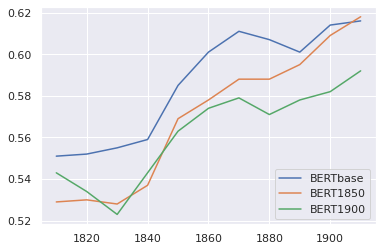

In [9]:
setting = "abstract"
weighting = "weighted"
metric = "fscore"

lemmas = dLemmas[setting]

time_experiment = 1920 # Folder from which we select results: "1850" or "1920"
test_daterange_start = 1760 # Quotations starting from
year_window = 50
bert_base = []
bert_1850 = []
bert_1900 = []
time_mean = []
for date_start in range(test_daterange_start, time_experiment - year_window,10):
    results = find_optimal_daterange_ts(Path('results_ts_' + str(time_experiment)), lemmas, date_start, year_window, metric, weighting)
    bert_base.append(results["bert_base_sense_centroid_" + weighting])
    bert_1850.append(results["bert_1850_sense_centroid_" + weighting])
    bert_1900.append(results["bert_1900_sense_centroid_" + weighting])
    time_mean.append(date_start + year_window)
    
plt.plot(time_mean, bert_base)
plt.plot(time_mean, bert_1850)
plt.plot(time_mean, bert_1900)

plt.legend(["BERTbase", "BERT1850", "BERT1900"], loc='lower right')

plt.savefig("figures/plot_LM_" + setting + "_class1" + metric + "_50_ts_" + weighting + ".png", dpi=300, bbox_inches="tight")

### Inspect differences between time-sensitive and standard

What do we gain by using the weighted method? And what do we lose with it? Compare quotations correclty labeled by the time-sensitive method and incorrectly labeled by the time-insensitive method, or viceversa.

In [10]:
def time_sensitive_exploration(results_path, lemmas, observed_LM, ts_method, improvement):
    from sklearn.metrics import precision_recall_fscore_support
    clf_dict = defaultdict(list)
    results = {}
    csv_files = results_path.glob("**/*.csv")
    years = []
    years_total = []
    for csv in csv_files:
        current_csv = str(csv).split("/")
        current_lemma = current_csv[1]
        current_sense = current_csv[3].split("~")[0]
        lemma_pickle = pd.read_pickle("data/lemma_senses_" + current_lemma + ".pickle")
        
        if current_lemma in lemmas:
            try:
                df = pd.read_csv(csv)

                df = df[["label","year","quotation_id","bert_centroid_sense_vector_" + observed_LM + "_-1,-2,-3,-4_mean",
                         "bert_ts_" + ts_method + "_centroid_sense_vector_" + observed_LM + "_-1,-2,-3,-4_mean"]]

                df = df.rename(columns={"bert_centroid_sense_vector_" + observed_LM + "_-1,-2,-3,-4_mean": observed_LM + "_standard",
                                        "bert_ts_" + ts_method + "_centroid_sense_vector_" + observed_LM + "_-1,-2,-3,-4_mean": observed_LM + "_" + ts_method})

            except Exception as e:
                continue

            filtered_df = pd.DataFrame()
            if improvement == "weighted":
                filtered_df = df[(df["label"] == 1) & (df[observed_LM + "_standard"] == 0) & (df[observed_LM + "_" + ts_method] == 1)]
            elif improvement == "standard":
                filtered_df = df[(df["label"] == 1) & (df[observed_LM + "_standard"] == 1) & (df[observed_LM + "_" + ts_method] == 0)]
            
            years += list(filtered_df["year"].values)
            years_total += list(df[df["label"] == 1]["year"].values)
    
    batch1 = [y for y in years if y >= 1770 and y <= 1800]
    batch2 = [y for y in years if y > 1800 and y <= 1830]
    batch3 = [y for y in years if y > 1830 and y <= 1860]
    batch4 = [y for y in years if y > 1860 and y <= 1890]
    batch5 = [y for y in years if y > 1890 and y <= 1920]
    
    batch1_total = [y for y in years_total if y >= 1770 and y <= 1800]
    batch2_total = [y for y in years_total if y > 1800 and y <= 1830]
    batch3_total = [y for y in years_total if y > 1830 and y <= 1860]
    batch4_total = [y for y in years_total if y > 1860 and y <= 1890]
    batch5_total = [y for y in years_total if y > 1890 and y <= 1920]
    
    return len(batch1)/len(batch1_total), len(batch2)/len(batch2_total), len(batch3)/len(batch3_total), len(batch4)/len(batch4_total), len(batch5)/len(batch5_total)

In [11]:
setting = "abstract"
metric = "fscore"
improvement = "weighted" # "weighted" to see improvement of weighted over standard
                         # "standard" to see improvement of standard over weighted

lemmas = dLemmas[setting]

lms = ["bert_1850", "blert_base", "bert_base"]

for improvement in ["weighted", "standard"]:
    print("Explore improvements by using:", improvement)
    print("==========================================")
    time_experiment = 1920 # Folder from which we select results
    # observed_LM = "bert_1850"
    for observed_LM in lms:
        print("Setting:", setting)
        print("EXP: 1760-" + str(time_experiment))
        print("LM:", observed_LM)
        ts_method = "weighted"
        batches = time_sensitive_exploration(Path('results_ts_' + str(time_experiment)), lemmas, observed_LM, ts_method, improvement)
        print("\tBatch 1750-1800:", batches[0])
        print("\tBatch 1800-1850:", batches[1])
        print("\tBatch 1850-1900:", batches[2])
        print("\tBatch 1900-1950:", batches[3])
        print("\tBatch 1950-2000:", batches[4])
        print("\tAll batches:", statistics.mean(batches))
        print()

Explore improvements by using: weighted
Setting: abstract
EXP: 1760-1920
LM: bert_1850
	Batch 1750-1800: 0.037037037037037035
	Batch 1800-1850: 0.11864406779661017
	Batch 1850-1900: 0.0759493670886076
	Batch 1900-1950: 0.125
	Batch 1950-2000: 0.12162162162162163
	All batches: 0.09565041870877529

Setting: abstract
EXP: 1760-1920
LM: blert_base


ZeroDivisionError: division by zero

# Data exploration

Code to generate table 1 describing the data:

In [3]:
import pandas as pd
from utils.classificaton_utils import binarize

words = [['anger',"NN"],["apple","NN"],["art","NN"],["democracy","NN"],
         ["happiness","NN"],["labour","NN"],["machine","NN"],["man","NN"],
         ["nation","NN"],["power","NN"],["slave","NN"],['woman','NN']]

experiment = {"start": 1760, "end": 1850, "filter_val": True, "filter_test": True}

dr = dict()
for lemma, pos in words:
    print("### lemma: {} ###".format(lemma))
    quotations_path = f"./data/sfrel_quotations_{lemma}_{pos}.pickle"
    lemma_senses = pd.read_pickle(f'./data/lemma_senses_{lemma}_{pos}.pickle')

    senses = set(lemma_senses[lemma_senses.word_id.str.startswith(f'{lemma}_{pos.lower()}')]["id"])
    relations = ['seed','synonym']
    eval_mode = "lemma_etal"

    df_train, df_val, df_test = binarize(lemma=lemma,
                                    pos=pos,
                                    senses=senses, 
                                    start=experiment["start"],
                                    end=experiment["end"],
                                    relations=relations,
                                    eval_mode=eval_mode,
                                    filter_val_by_year=experiment["filter_val"],
                                    filter_test_by_year=experiment["filter_test"],
                                    strict_filter=True)

    df_all = pd.concat([df_train, df_val, df_test])
    
    unique_seed_senses = len(df_all[df_all["provenance_type"] == "seed"]["sense_id"].unique())
    unique_syn_senses = round(len(df_all[df_all["provenance_type"] == "synonym"]["sense_id"].unique())/unique_seed_senses)
    unique_other_senses = round(len(df_all[~df_all["provenance_type"].isin(["synonym", "seed"])]["sense_id"].unique())/unique_seed_senses)
    df_all_posq = df_all[df_all["label"] == "1"]
    df_all_negq = df_all[df_all["label"] == "0"]
    quotations_p = round(len(df_all_posq.quotation_id.unique())/unique_seed_senses)
    quotations_n = round(len(df_all_negq.quotation_id.unique())/unique_seed_senses)
    quotations = str(quotations_p) + "/" + str(quotations_n)
    derived_senses = str(unique_syn_senses) + "/" + str(unique_other_senses)
     
    dr[lemma] = [unique_seed_senses, derived_senses, quotations]
    
data_description = pd.DataFrame.from_dict(dr, orient='index', columns=['Seeds','ExpSenses', 'Quotations'])

/data/anaconda/envs/py37torch/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
### lemma: anger ###
[LOG] # senses before filtering by date = 442
[LOG] # senses after filtering by date = 198
[LOG] # of seed senses 11 
[LOG] # of synonyms 177 
[LOG] # of branch senses 0
[LOG] # of seeds selected 3 
[LOG] # of synonyms selected 120 
[LOG] # of branches selected 0
[LOG] 4001 quotations selected
[LOG] train = 3642 val = 126 test = 233 quotations
### lemma: apple ###
[LOG] # senses before filtering by date = 306
[LOG] # senses after filtering by date = 170
[LOG] # of seed senses 10 
[LOG] # of synonyms 150 
[LOG] # of branch senses 0
[LOG] # of seeds selected 10 
[LOG] # of synonyms selected 150 
[LOG] # of branches selected 0
[LOG] 6388 quotations selected
[LOG] train = 5803 val = 209 test = 376 quotations
### lemma: art ###
[LOG] 

In [4]:
print(data_description.to_latex())

\begin{tabular}{lrll}
\toprule
{} &  Seeds & ExpSenses & Quotations \\
\midrule
anger     &      6 &    17/121 &    103/564 \\
apple     &     19 &      6/61 &     36/300 \\
art       &     19 &      5/47 &     33/212 \\
democracy &      7 &      6/61 &     37/301 \\
happiness &      5 &      9/46 &     57/186 \\
labour    &     18 &      4/30 &     29/148 \\
machine   &     25 &      8/83 &     42/361 \\
man       &     48 &      9/78 &     55/380 \\
nation    &     15 &      8/85 &     53/430 \\
power     &     39 &      5/49 &     34/244 \\
slave     &     10 &    20/158 &    103/670 \\
woman     &     17 &     10/81 &     64/379 \\
\bottomrule
\end{tabular}

